In [1]:
import pandas as pd
import numpy as np

import torch

import data_utils.pulse as pulse #sean's code
import models.rf as models_rf
import models.fcnn as models_fcnn
import models.vae as models_vae

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import manifold

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

In [3]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

## Read dataset

In [4]:
filename='datasets/galadriel_dataset_25_05_20b.h5'

df_input=pd.read_hdf(filename,'df_input')#dazzler parameters + goodness
df_time=pd.read_hdf(filename,'df_time') #wizzler pulse shape data, first row is the time values

df_time_val=df_time.loc[0]
df_time= df_time.drop([0]) #drop the time values
df_time.reset_index(inplace=True,drop=True) #to start again from 0

#frequency, intesity and phase from the Wizzler (used to reconstruct pulse using Sean's code)
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

In [5]:
df_input

,shot number,order2,order3,order4,goodness
0,228398,34400.0,-23000.0,-5200000.0,0.973197
1,228399,34400.0,-23000.0,-5200000.0,1.025389
2,228400,34400.0,-23000.0,-5200000.0,0.878544
3,228401,34400.0,-23000.0,-4900000.0,0.951341
4,228402,34400.0,-23000.0,-4900000.0,1.064822
...,...,...,...,...,...
2767,231165,35400.0,16000.0,-4000000.0,0.883351
2768,231166,35400.0,16000.0,-4000000.0,0.874706
2769,231167,35400.0,16000.0,-3700000.0,0.879835
2770,231168,35400.0,16000.0,-3700000.0,0.882060


## Pulse reconstruction

In [6]:
#time in fs (it is the boundary)
def pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [7]:
filename_pulse='datasets/pulse_250520b.h5'

In [8]:
#read the data
df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

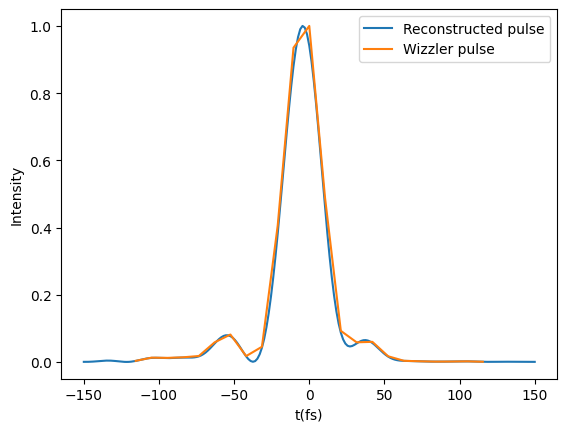

In [9]:
shot_index=35
plt.plot(t_200,df_pulse_200.iloc[shot_index],label='Reconstructed pulse')
plt.plot(df_time_val,df_time.iloc[shot_index],label='Wizzler pulse')
plt.xlabel('t(fs)')
plt.ylabel('Intensity')
plt.legend()

## Create the training/test datasets

(Here we should do some cleaning. Remove bad goodness shots....)

In [10]:
#DROP SHOTS witl low goodness
goodness_val=1.2
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values

df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

In [11]:
#X: df_input (Dazzler parameters)
#Y: df_pulse (Pulse shapes)
X=df_input_reduced[['order2','order3','order4']]
y=df_pulse_200_reduced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [12]:
X_train

,order2,order3,order4
118,34400.0,16000.0,-4000000.0
389,34700.0,-23000.0,-5200000.0
448,34700.0,-5000.0,-4900000.0
598,34800.0,-5000.0,-4300000.0
901,35100.0,4000.0,-5200000.0
...,...,...,...
575,34800.0,-11000.0,-4900000.0
973,35200.0,4000.0,-4900000.0
75,34400.0,7000.0,-4600000.0
599,34800.0,-2000.0,-4900000.0


## Plot goodness

In [13]:
#reference values
beta2=35000
beta3=0
beta4=-4.5e6

In [14]:
#define a set with the bad goodness shots
df_input_bad=df_input[df_input['goodness']<goodness_val]

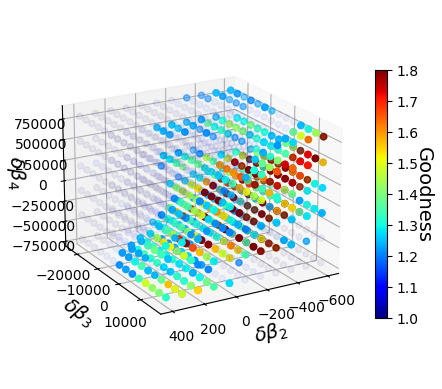

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d= ax.scatter(df_input_reduced['order2']-beta2, df_input_reduced['order3']-beta3, df_input_reduced['order4']-beta4,c=df_input_reduced['goodness'],
                    cmap='jet',vmin=1.0,vmax=1.8)
ax.scatter(df_input_bad['order2']-beta2, df_input_bad['order3']-beta3, df_input_bad['order4']-beta4,c=df_input_bad['goodness'],
                    cmap='jet',vmin=1.0,vmax=1.8,alpha=0.02)
ax.set_xlabel(r'$\delta\beta_2$',fontsize=14)
ax.set_ylabel(r'$\delta\beta_3$',fontsize=14)
ax.set_zlabel(r'$\delta\beta_4$',fontsize=14)
ax.view_init(elev=20., azim=60)
#plt.title('Goodness')
cbar = plt.colorbar(plot_3d,fraction=0.025, pad=-0.01)
cbar.ax.set_ylabel('Goodness', rotation=270,labelpad=10,fontsize=14)
ax.set_box_aspect(None, zoom=0.85)
plt.show()
#crop the figure with any online tool to remove the boundaries

## Model training (Forward)

### Random forest

In [16]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    #HYPERPARAMETERS
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=models_rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=models_rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf

In [17]:
%%time
forward_model_rf=train_rf_forward(X_train, X_test, y_train, y_test)

CPU times: user 1.3 s, sys: 76 ms, total: 1.38 s
Wall time: 1.38 s


### Multi-layer perceptron (MLP)

In [18]:
device='cpu' #could be gpus if available
forward_model_mlp=models_fcnn.FWmodelNN(X_train,y_train,X_test,y_test,device)
forward_model_mlp.train(100,#epochs 
                 128,#batch size
                 10, #print freq
                 0.001) #learning rate
y_predict_nn_fwd=forward_model_mlp.predict(X_test)
error_fwd_model_mlp=forward_model_mlp.error_calc_mae()

Finished epoch 0,latest loss 0.06821893900632858
Finished epoch 10,latest loss 0.0015816960949450731
Finished epoch 20,latest loss 0.001517475233413279
Finished epoch 30,latest loss 0.0014032790204510093
Finished epoch 40,latest loss 0.0012005092576146126
Finished epoch 50,latest loss 0.0007382656913250685
Finished epoch 60,latest loss 0.00035815415321849287
Finished epoch 70,latest loss 0.00023601690190844238
Finished epoch 80,latest loss 0.00018653945880942047
Finished epoch 90,latest loss 0.00014688775991089642
Finished epoch 99,latest loss 0.00012784202408511192
Total time taken to train the model: 4.57s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

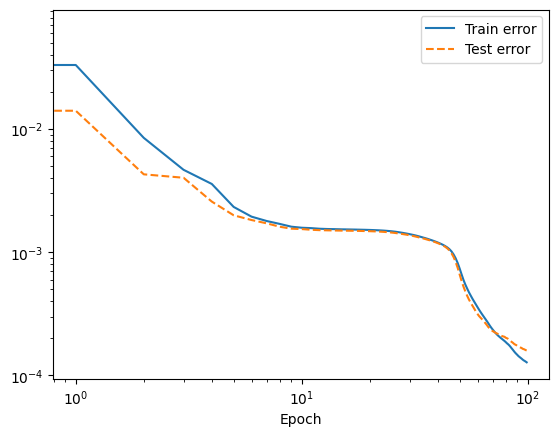

In [19]:
plt.plot(forward_model_mlp.train_error,label='Train error')
plt.plot(forward_model_mlp.test_error,linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

In [20]:
def plot_example(shot_index,X_test,y_test,df_input,df_time_val,
                 forward_model_rf,forward_model_mlp):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=X_test.iloc[shot_index].values
    
    X_values=pd.DataFrame([X_test.iloc[shot_index]])
    y_predict_forward_rf=models_rf.make_rf_prediction(forward_model_rf,X_values)
    y_predict_forward_nn=forward_model_mlp.predict(X_values)
    
    plt.plot(df_time_val,y_test.iloc[shot_index],label='Real shot (#'+str(shot_numb)+')',linewidth=3)
    plt.plot(df_time_val,y_predict_forward_rf[0],label='Prediction (RF)',linewidth=3,linestyle='--')
    plt.plot(df_time_val,y_predict_forward_nn[0],label='Prediction (MLP)',linewidth=3,linestyle='-.')
    
    mae_rf=abs(y_test.iloc[shot_index]-y_predict_forward_rf[0])
    mae_rf=mae_rf.sum()/len(y_test.iloc[shot_index])

    mae_mlp=abs(y_test.iloc[shot_index]-y_predict_forward_nn[0])
    mae_mlp=mae_mlp.sum()/len(y_test.iloc[shot_index])

    #mae='{:6.2f}'.format(100*mean_absolute_error(y_test.iloc[shot_index],y_predict_forward[shot_index]))
    plt.title('Forward predictions',fontsize=14)
    plt.text(45, 0.65, r'$\beta_2=$'+str(order2), dict(size=14))
    plt.text(45, 0.55, r'$\beta_3=$'+str(order3), dict(size=14))
    plt.text(45, 0.45, r'$\beta_4=$'+str(order4), dict(size=14))
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf))
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

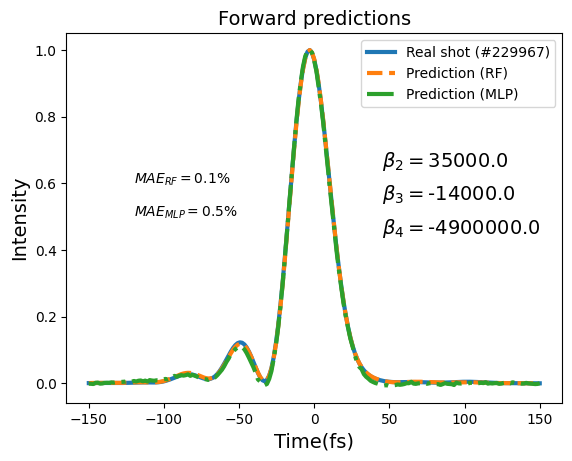

In [21]:
shot_index=120
plot_example(shot_index,X_test,y_test,df_input_reduced,t_200,
             forward_model_rf,forward_model_mlp)

# **** ROUNDTRIP MODELS  *****

### Random Forest

In [22]:
%%time
roundmodel_rf=models_rf.ROUNDmodelRF(X_train,X_test,y_train,y_test)
roundmodel_rf.train()
y_predict_round=roundmodel_rf.predict(y_test)

Training the Random Forest forward model
Training the Random Forest backward model
CPU times: user 25.2 s, sys: 94.9 ms, total: 25.3 s
Wall time: 25.3 s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### MLP

In [23]:
#round model NN
roundmodel_mlp=models_fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodel_mlp.train(100,#epochs FWD
                 128,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   400,#epochs  BWD
                 128,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round=roundmodel_mlp.predict(y_test)

Training the forward model
Finished epoch 0,latest loss 0.07087861001491547
Finished epoch 20,latest loss 0.0014511474873870611
Finished epoch 40,latest loss 0.0003739634121302515
Finished epoch 60,latest loss 0.0002312523138243705
Finished epoch 80,latest loss 0.0001810505782486871
Finished epoch 99,latest loss 0.0001559524971526116
Total time taken to train the model: 3.02s
Training the backward model
Finished epoch 0,latest loss 1.0311726331710815
Finished epoch 50,latest loss 0.1848924458026886
Finished epoch 100,latest loss 0.07625970244407654
Finished epoch 150,latest loss 0.0481807217001915
Finished epoch 200,latest loss 0.035635314881801605
Finished epoch 250,latest loss 0.028798852115869522
Finished epoch 300,latest loss 0.024623481556773186
Finished epoch 350,latest loss 0.024006158113479614
Finished epoch 399,latest loss 0.019349507987499237
Total time taken to train the model: 15.11s


Text(0.5, 0, 'Epoch')

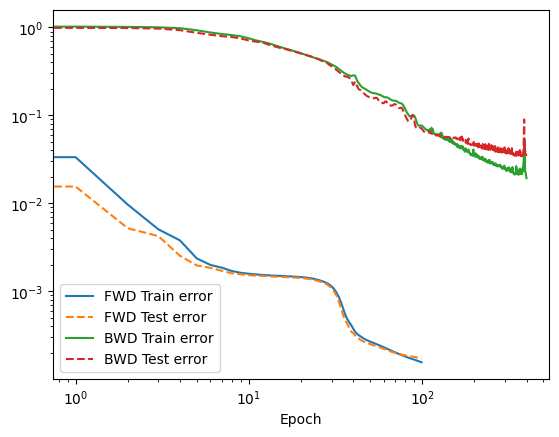

In [24]:
plt.plot(roundmodel_mlp.train_error_fwd,label='FWD Train error')
plt.plot(roundmodel_mlp.test_error_fwd,linestyle='--',label='FWD Test error')
plt.plot(roundmodel_mlp.train_error_bwd,label='BWD Train error')
plt.plot(roundmodel_mlp.test_error_bwd,linestyle='--',label='BWD Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### CVAE

In [25]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
cvae=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
)
#if you want to see a description of the network
#batch_size = 10#just as an example
#y_length=len(t_200)
#x_length=len(X_train.columns)
#summary(cvae,[(batch_size,x_length),(batch_size,y_length)]) #from torchinfo import summary

In [26]:
model_cvae,train_error,test_error=models_vae.train_vae(y_train,y_test,X_train,X_test,
			cvae,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

Training on: cpu
Finished epoch 0,latest loss 0.9781692624092102
Finished epoch 20,latest loss 0.11334425210952759
Finished epoch 40,latest loss 0.09703533351421356
Finished epoch 60,latest loss 0.060356661677360535
Finished epoch 80,latest loss 0.0377669557929039
Finished epoch 100,latest loss 0.04331278055906296
Finished epoch 120,latest loss 0.016460219398140907
Finished epoch 140,latest loss 0.013791377656161785
Finished epoch 160,latest loss 0.017115332186222076
Finished epoch 180,latest loss 0.018451448529958725
Finished epoch 200,latest loss 0.011712010949850082
Finished epoch 220,latest loss 0.010910343378782272
Finished epoch 240,latest loss 0.011908935382962227
Finished epoch 260,latest loss 0.009042073972523212
Finished epoch 280,latest loss 0.009345809929072857
Finished epoch 299,latest loss 0.007727161981165409
Total time taken to train the model: 26.03s


Text(0.5, 0, 'Epoch')

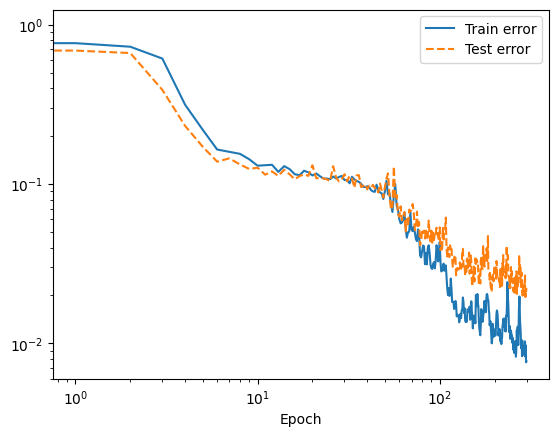

In [27]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

## Testing the predictions from the Roundtrip models

In [28]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
def pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,y_test,device):
    #index_shot=150
    y_ex=y_test.iloc[index_shot]
    X_ex=X_test.iloc[index_shot]
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    print(len(y_ex))
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex)))
    print('Known Dazzler values',X_ex)

    shot_numb=get_shot_num(index_shot,y_test,df_input)


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    
    y_order2=np.linspace(0,1,10)
    x_order2=np.full_like(y_order2,X_ex['order2'])

    y_order3=np.linspace(0,1,10)
    x_order3=np.full_like(y_order3,X_ex['order3'])

    y_order4=np.linspace(0,1,10)
    x_order4=np.full_like(y_order4,X_ex['order4'])


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    mae_rf=abs(y_ex-y_predict_round_rf)
    mae_rf=mae_rf.sum()/len(y_ex)

    mae_mlp=abs(y_ex-y_predict_round_nn_cust)
    mae_mlp=mae_mlp.sum()/len(y_ex)

    mae_cvae=abs(y_ex-y_pred_fwd_cvae)
    mae_cvae=mae_cvae.sum()/len(y_ex)

    plt.subplot(1,5,(3,5))#one row, 4 columns, spanning from the first to the third
    plt.plot(t_200,y_ex,label='Real shot (#'+str(shot_numb)+')',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef',linewidth=3,color='tab:orange')
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF',linewidth=3,color='tab:green')
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP',linewidth=3,color='tab:red')
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf),fontsize=16)
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp),fontsize=16)
    plt.text(-120,0.4,r'$MAE_{{CVAE}}={:.1f}$%'.format(100*mae_cvae),fontsize=16)
    plt.ylabel('Intensity',size=15)
    plt.xlabel('t(fs)',size=15)
    plt.legend(fontsize=14)

    plt.subplot(3,5,(1,2))#(3, 2, 1)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'CVAE pred. $P(\beta_2|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order2,y_order2,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o2_rf,y_o2_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o2_nn,y_o2_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_2$',size=15)
    #plt.legend(fontsize=11)

    plt.subplot(3,5,(6,7))#(3, 2, 1)
    plt.hist(df_input['order3'],bins=17,weights=weights_input3,histtype="step",label=r'$P(\beta_x)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'CVAE pred. $P(\beta_x|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order3,y_order3,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o3_rf,y_o3_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o3_nn,y_o3_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(11,12))#(3, 2, 1)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'CVAE pred $P(\beta_4|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order4,y_order4,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o4_rf,y_o4_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o4_nn,y_o4_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_4$',size=15)
    #plt.legend(fontsize=11)

    fig = plt.gcf()
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    plt.show()

201
Known Dazzler values order2      34600.0
order3      -5000.0
order4   -4600000.0
Name: 318, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


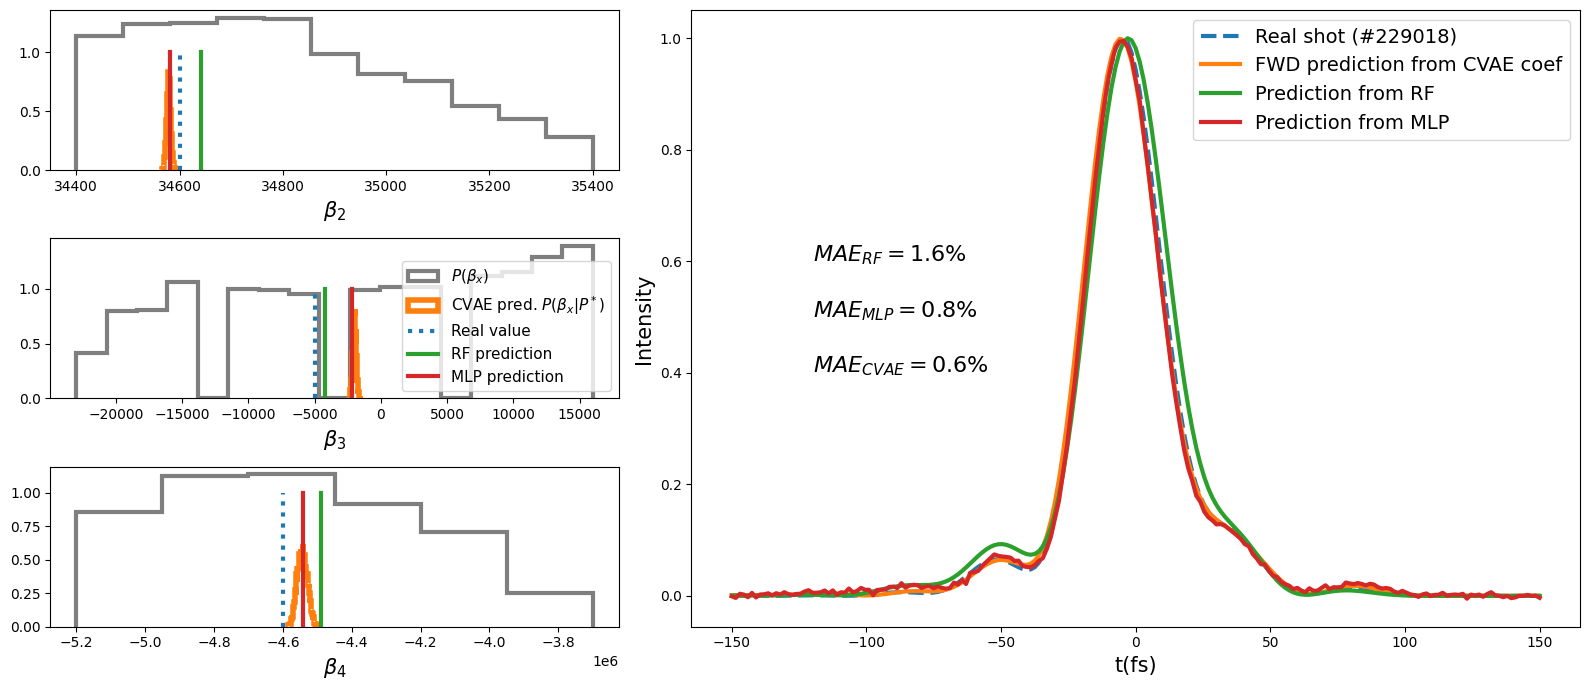

In [29]:
index_shot=106
pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,y_test,device)

# CUSTOM SHOTS

**NOTE**: The CVAE model was executed on GALADRIEL system and the predicted Dazzler coefficients were used. So here we don't take into account the backward prediction because could be different thant the one obtained that day and the ones calculated in my laptop.

In the experiment, 4 shots were executed for each custom shot

### Read the dataset from the prediction run

In [30]:
filename_pred='datasets/galadriel_dataset_25_05_20b_pred.h5'

df_input_pred=pd.read_hdf(filename_pred,'df_input')#dazzler parameters + goodness

In [31]:
df_input_pred

,shot number,order2,order3,order4,goodness
0,231191,34296.480469,8610.262695,-4124345.75,1.236933
1,231192,34296.480469,8610.262695,-4124345.75,1.257958
2,231193,34296.480469,8610.262695,-4124345.75,1.241748
3,231194,34296.480469,8610.262695,-4124345.75,1.253691
4,231195,32459.712891,17531.728516,-2656397.25,1.033337
5,231196,32459.712891,17531.728516,-2656397.25,1.023243
6,231197,32459.712891,17531.728516,-2656397.25,1.043056
7,231198,32459.712891,17531.728516,-2656397.25,1.042557
8,231199,31861.964844,-14996.779297,-2170342.25,0.964587
9,231200,31861.964844,-14996.779297,-2170342.25,0.959264


### Pulse reconstruction

In [32]:
#frequency, intesity and phase from the Wizzler (used to reconstruct pulse using Sean's code)
df_spec_freq_pred=pd.read_hdf(filename_pred,'df_spec_freq')
df_spec_int_pred=pd.read_hdf(filename_pred,'df_spec_int')
df_spec_phase_pred=pd.read_hdf(filename_pred,'df_spec_phase')

In [33]:
filename_pulse_pred='datasets/pulse_250520b_pred.h5'

In [34]:
#read the data
df_time_200_pred=pd.read_hdf(filename_pulse_pred,'df_time_200')
df_pulse_200_pred=pd.read_hdf(filename_pulse_pred,'df_pulse_200')
t_200_pred=df_time_200_pred.to_numpy()

In [35]:
def pred_cvae(model_cvae,y_ex_tensor,X_train,device):
    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    num_bins=100

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]
    
    return o2_pred, o3_pred, o4_pred

In [ ]:
#Similar function as above but plotting the shots horizonally
#Take a custom pulse shpae (y_ex) and get the predicted Dazz and pulse shape from CVAE.
# Then the pulse is compared with the value from the exp run
# X_train in the input is the dataset used to normalized the X
# Pass the df_input_pred as a Series with only one shot
def pred_cust_cvae(y_ex_1,y_pred_1,df_input_pred_1,
                   y_ex_2,y_pred_2,df_input_pred_2,
                   y_ex_3,y_pred_3,df_input_pred_3,
                   model_cvae,forward_model_rf,
                   t_200,X_train,device,t_200_pred,
                   beta_ref_values):
    #prediction1
    y_ex_tensor=torch.tensor(y_ex_1,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
    o2_pred_1, o3_pred_1, o4_pred_1 = pred_cvae(model_cvae,y_ex_tensor,X_train,device)

    #prediction2
    y_ex_tensor=torch.tensor(y_ex_2,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
    o2_pred_2, o3_pred_2, o4_pred_2 = pred_cvae(model_cvae,y_ex_tensor,X_train,device)

    #prediction3
    y_ex_tensor=torch.tensor(y_ex_3,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
    o2_pred_3, o3_pred_3, o4_pred_3 = pred_cvae(model_cvae,y_ex_tensor,X_train,device)

    #Forward prediction using CVAE backward prediction
    y_pred_fwd_cvae_1=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred_1,o3_pred_1,o4_pred_1)]))[0]
    y_pred_fwd_cvae_2=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred_2,o3_pred_2,o4_pred_2)]))[0]
    y_pred_fwd_cvae_3=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred_3,o3_pred_3,o4_pred_3)]))[0]

    #mae_cvae=abs(y_pred-y_pred_fwd_cvae)
    #mae_cvae=mae_cvae.sum()/len(y_pred)

    #print('PREDICTIONS (in my laptop):')
    #print('*CVAE:')
    #print(' -Order2:',o2_pred)
    #print(' -Order3:',o3_pred)
    #print(' -Order4:',o4_pred)

    shot_numb_1=int(df_input_pred_1["shot number"])#get_shot_num(shot_index,y_test,df_input)
    shot_numb_2=int(df_input_pred_2["shot number"])#get_shot_num(shot_index,y_test,df_input)
    shot_numb_3=int(df_input_pred_3["shot number"])#get_shot_num(shot_index,y_test,df_input)

    order2_1="{:.1e}".format(df_input_pred_1["order2"]-beta_ref_values[0])#get teh value and convert to str with 1value after .
    order3_1="{:.1e}".format(df_input_pred_1["order3"]-beta_ref_values[1])
    order4_1="{:.1e}".format(df_input_pred_1["order4"]-beta_ref_values[2])

    order2_2="{:.1e}".format(df_input_pred_2["order2"]-beta_ref_values[0])#get teh value and convert to str with 1value after .
    order3_2="{:.1e}".format(df_input_pred_2["order3"]-beta_ref_values[1])
    order4_2="{:.1e}".format(df_input_pred_2["order4"]-beta_ref_values[2])

    order2_3="{:.1e}".format(df_input_pred_3["order2"]-beta_ref_values[0])#get teh value and convert to str with 1value after .
    order3_3="{:.1e}".format(df_input_pred_3["order3"]-beta_ref_values[1])
    order4_3="{:.1e}".format(df_input_pred_3["order4"]-beta_ref_values[2])

    #calculate the MAE of the custom shot vs experimental shot
    mae_exp_1=abs(y_ex_1-y_pred_1)
    mae_exp_1=mae_exp_1.sum()/len(y_ex_1)
    mae_exp_2=abs(y_ex_2-y_pred_2)
    mae_exp_2=mae_exp_2.sum()/len(y_ex_2)
    mae_exp_3=abs(y_ex_3-y_pred_3)
    mae_exp_3=mae_exp_3.sum()/len(y_ex_3)

    #define x limits for the 3 plots
    limit_min_x=-120
    limit_max_x=120

    ax1=plt.subplot(1,3,1)
    plt.plot(t_200,y_ex_1,label='Custom shot',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae_1,label='CVAE prediction',linewidth=3,color='tab:orange')
    plt.plot(t_200_pred,y_pred_1,label='Real shot (#'+str(shot_numb_1)+')',linewidth=3,color='tab:green')
    plt.legend()
    plt.ylabel('Intensity',fontsize=14)
    plt.text(-100, 0.15, r'(a)', dict(size=14))
    plt.text(-110, 0.90, r'$\delta\beta_2=$'+order2_1, dict(size=10))
    plt.text(-110, 0.80, r'$\delta\beta_3=$'+order3_1, dict(size=10))
    plt.text(-110, 0.70, r'$\delta\beta_4=$'+order4_1, dict(size=10))
    plt.text(30, 0.90, r'$MAE={:.1f}$%'.format(100*mae_exp_1), dict(size=10))
    plt.xlim([limit_min_x, limit_max_x])
    plt.xlabel('Time(fs)',fontsize=14)
    

    ax2=plt.subplot(1,3,2)
    plt.title('Custom shots: prediction and result',fontsize=14)
    plt.plot(t_200,y_ex_2,linestyle='--',linewidth=3,color='tab:blue') #label='Custom shot',
    plt.plot(t_200,y_pred_fwd_cvae_2,linewidth=3,color='tab:orange') #,label='CVAE prediction'
    plt.plot(t_200_pred,y_pred_2,label='Real shot (#'+str(shot_numb_2)+')',linewidth=3,color='tab:green')
    plt.legend()
    plt.text(-100, 0.15, r'(b)', dict(size=14))
    plt.text(-110, 0.90, r'$\delta\beta_2=$'+order2_2, dict(size=10))
    plt.text(-110, 0.80, r'$\delta\beta_3=$'+order3_2, dict(size=10))
    plt.text(-110, 0.70, r'$\delta\beta_4=$'+order4_2, dict(size=10))
    plt.text(30, 0.90, r'$MAE={:.1f}$%'.format(100*mae_exp_2), dict(size=10))
    plt.xlim([limit_min_x, limit_max_x])
    plt.xlabel('Time(fs)',fontsize=14)
    ax2.set_yticklabels([])

    ax3=plt.subplot(1,3,3)
    plt.plot(t_200,y_ex_3,linestyle='--',linewidth=3,color='tab:blue') #label='Custom shot'
    plt.plot(t_200,y_pred_fwd_cvae_3,linewidth=3,color='tab:orange') #,label='CVAE prediction'
    plt.plot(t_200_pred,y_pred_3,label='Real shot (#'+str(shot_numb_3)+')',linewidth=3,color='tab:green')
    plt.text(-100, 0.15, r'(c)', dict(size=14))
    plt.text(-110, 0.90, r'$\delta\beta_2=$'+order2_3, dict(size=10))
    plt.text(-110, 0.80, r'$\delta\beta_3=$'+order3_3, dict(size=10))
    plt.text(-110, 0.70, r'$\delta\beta_4=$'+order4_3, dict(size=10))
    plt.text(30, 0.90, r'$MAE={:.1f}$%'.format(100*mae_exp_3), dict(size=10))
    plt.xlim([limit_min_x, limit_max_x])
    ax3.set_yticklabels([])
   
    
    #plt.text(45, 0.65, r'$\beta_2=$'+order2, dict(size=14))
    #plt.text(45, 0.55, r'$\beta_3=$'+order3, dict(size=14))
    #plt.text(45, 0.45, r'$\beta_4=$'+order4, dict(size=14))
    #plt.text(-120,0.6,r'$MAE_{{pred}}={:.1f}$%'.format(100*mae_cvae))
    #plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    #plt.ylabel('Intensity',fontsize=14)
    plt.legend()
    #change the size of the figure
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    fig.tight_layout()
    # Save figure in EPS format
    #plt.savefig('cust_shot.eps', format='eps', dpi=300, bbox_inches='tight')
    #plt.show()


In [55]:
#define the curve to fit (the custom pulse shape)
# It's just 5 gaussians
def func(t,a0, a1,a2,
        b0,b1,b2,
        c0,c1,c2,
        d0,d1,d2,
        e0,e1,e2): 
    #envelope=1*np.exp(-((t-0)**2)/(2*30*30))
    return (a0*np.exp(-((t-a1)**2)/(2*a2*a2))
            +b0*np.exp(-((t-b1)**2)/(2*b2*b2))
           +c0*np.exp(-((t-c1)**2)/(2*c2*c2))
           +d0*np.exp(-((t-d1)**2)/(2*d2*d2))
           +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))

In [56]:
beta_ref_values=[beta2,beta3,beta4] 

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


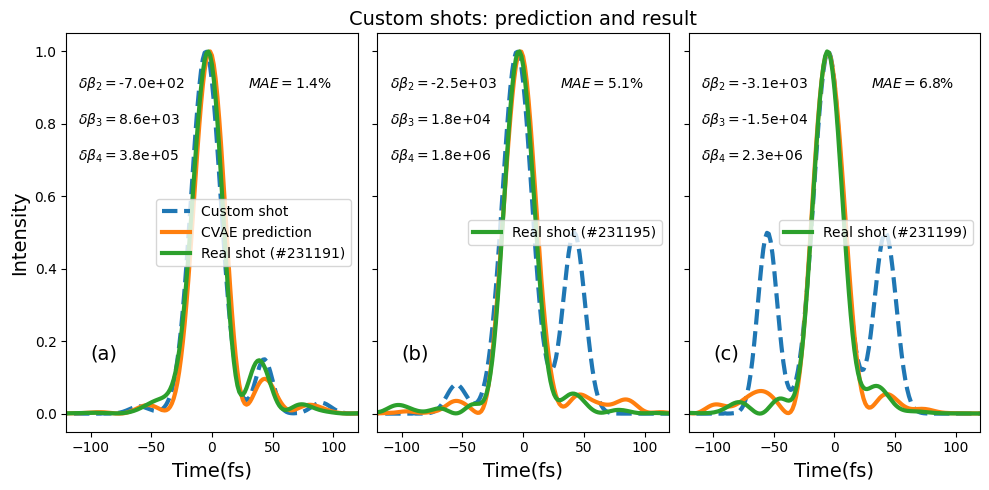

In [57]:
#FIRST SHOT
y_cust_shot_1=func(t_200,
                 0.001,-90,0.1,
                 0.02,-60,8,
                 1,-5,12,
                 0.15,+43,7,
                 0.03,+90,8)

pred_shot_index_1=0
y_pred_1=df_pulse_200_pred.iloc[pred_shot_index_1]
meta_pred_1=df_input_pred.iloc[pred_shot_index_1]

#SECOND SHOT
y_cust_shot_2=func(t_200,
                 0.001,-90,0.1,
                 0.08,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_shot_index_2=4
y_pred_2=df_pulse_200_pred.iloc[pred_shot_index_2]
meta_pred_2=df_input_pred.iloc[pred_shot_index_2]

#THIRD SHOT
y_cust_shot_3=func(t_200,
                 0.001,-90,0.1,
                 0.5,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_shot_index_3=8
y_pred_3=df_pulse_200_pred.iloc[pred_shot_index_3]
meta_pred_3=df_input_pred.iloc[pred_shot_index_3]

pred_cust_cvae(y_cust_shot_1,y_pred_1,meta_pred_1,
               y_cust_shot_2,y_pred_2,meta_pred_2,
               y_cust_shot_3,y_pred_3,meta_pred_3,
               model_cvae,forward_model_rf,
               t_200,X_train,device,t_200_pred,
               beta_ref_values)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


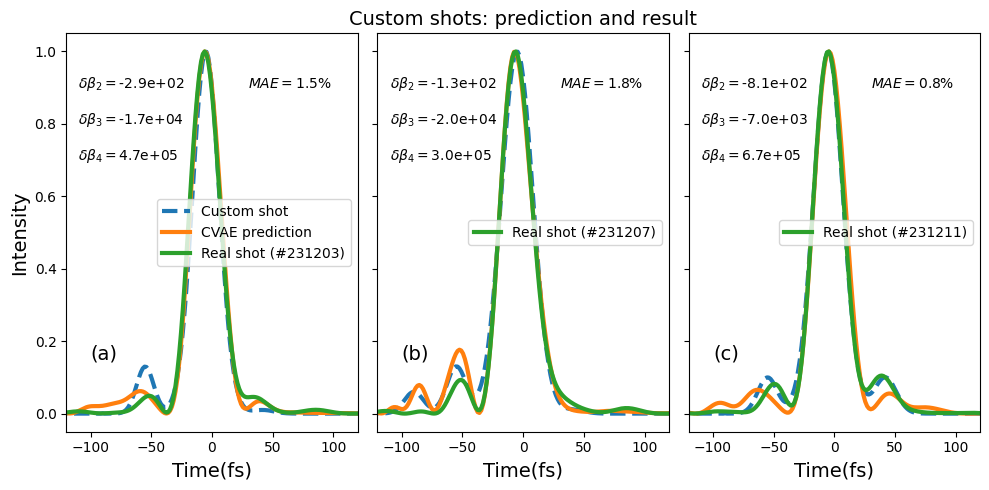

In [58]:
#FOURTH SHOT
y_cust_shot_4=func(t_200,
                 0.001,-90,0.1,
                 0.13,-55,7,
                 1,-5,11,
                 0.01,+42,9,
                 0.00,+90,8)

pred_shot_index_4=12
y_pred_4=df_pulse_200_pred.iloc[pred_shot_index_4]
meta_pred_4=df_input_pred.iloc[pred_shot_index_4]

#FIFTH SHOT
y_cust_shot_5=func(t_200,
                 0.06,-90,8,
                 0.13,-55,8,
                 1,-5,13,
                 0.01,+42,9,
                 0.00,+90,8)

pred_shot_index_5=16
y_pred_5=df_pulse_200_pred.iloc[pred_shot_index_5]
meta_pred_5=df_input_pred.iloc[pred_shot_index_5]

#SIXTH SHOT
y_cust_shot_6=func(t_200,
                 0.001,-90,0.1,
                 0.1,-55,8,
                 1,-5,12,
                 0.10,+42,9,
                 0.00,+90,8)

pred_shot_index_6=20
y_pred_6=df_pulse_200_pred.iloc[pred_shot_index_6]
meta_pred_6=df_input_pred.iloc[pred_shot_index_6]

pred_cust_cvae(y_cust_shot_4,y_pred_4,meta_pred_4,
               y_cust_shot_5,y_pred_5,meta_pred_5,
               y_cust_shot_6,y_pred_6,meta_pred_6,
               model_cvae,forward_model_rf,
               t_200,X_train,device,t_200_pred,
               beta_ref_values)

### Plot an envelope of all the shots

In [41]:
#define a reference shot close to the FTL best compression shot (o2=35000, o3=0, and o4=-4.5e6)
df_input_reduced[(df_input_reduced['order2']==35000) &
(df_input_reduced['order3']>-2000) & (df_input_reduced['order3']<2000)]

,shot number,order2,order3,order4,goodness
810,230054,35000.0,1000.0,-5200000.0,1.216796
811,230055,35000.0,1000.0,-5200000.0,1.219859
812,230056,35000.0,1000.0,-5200000.0,1.227846
813,230057,35000.0,1000.0,-4900000.0,1.642482
814,230058,35000.0,1000.0,-4900000.0,1.472629
815,230059,35000.0,1000.0,-4900000.0,1.528619
816,230060,35000.0,1000.0,-4600000.0,1.506659
817,230061,35000.0,1000.0,-4600000.0,1.445589
818,230062,35000.0,1000.0,-4600000.0,1.427983


In [42]:
#define a reference shot close to the FTL (o2=35000, o3=0, and o4=-4.5e6)
#for example 230060
shot_ftl=230060
ref_index=df_input_reduced[df_input_reduced['shot number']==shot_ftl].index.values[0]
print(ref_index)
ftl_shot=df_pulse_200_reduced.iloc[ref_index]

816


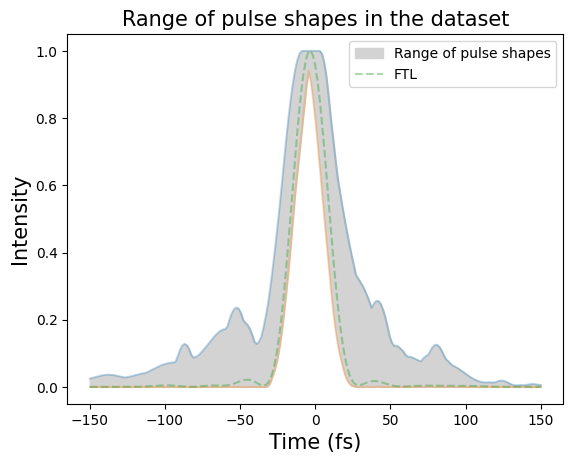

In [43]:
#get the maximum of each column
max_values=df_pulse_200_reduced.max()
min_values=df_pulse_200_reduced.min()
#fill between the max and min values
plt.fill_between(t_200,max_values,min_values,color='lightgrey',label='Range of pulse shapes')

plt.plot(t_200,max_values,alpha=0.3)
plt.plot(t_200,min_values,alpha=0.3)
plt.plot(t_200,ftl_shot,label='FTL',linestyle='--',alpha=0.4,color='tab:green')
plt.xlabel('Time (fs)',size=15)
plt.ylabel('Intensity',size=15)
plt.title('Range of pulse shapes in the dataset',size=15)
plt.legend()

## Random shooting

We first calculate the error (MAE) of one of the custom pulse shapes. Then we randomly sampling from the dataset to get a shot with similar error

In [44]:
#Take the sixth shot
y_cust_shot=y_cust_shot_1 #6
pred_shot_index=0#20

y_pred=df_pulse_200_pred.iloc[pred_shot_index]
#calculate the MAE from custom shot vs experimental shot
mae_pred=abs(y_cust_shot-y_pred)
mae_pred=mae_pred.sum()/len(y_cust_shot)
print('MAE sixth shot custom vs experimental: {:.1f}%'.format(100*mae_pred))

mae_rand=10000.0
counter=0
while mae_rand>mae_pred and counter<len(df_pulse_200_reduced):
    counter+=1
    #select a random shot
    rand_index=np.random.randint(0,len(df_pulse_200_reduced)-1)
    y_rand=df_pulse_200_reduced.iloc[rand_index]
    mae_rand_temp=abs(y_cust_shot-y_rand)
    mae_rand_temp=mae_rand_temp.sum()/len(y_cust_shot)
    if mae_rand_temp<mae_rand:
        mae_rand=mae_rand_temp
print('Number of random shots to beat the custom shot MAE: {}'.format(counter))
print('Best MAE from random shots: {:.1f}%'.format(100*mae_rand))

MAE sixth shot custom vs experimental: 1.4%
Number of random shots to beat the custom shot MAE: 1
Best MAE from random shots: 1.4%


In [45]:
len(df_pulse_200)

2772

## VISUALIZATION OF LATENT SPACE

In [46]:
#norm the X (Dazz parameters) (same as we did for training the CVAE)
X_test_norm=models_vae.norm_data(X_test,X_train)
X_train_norm=models_vae.norm_data(X_train,X_train)

#convert data to tensors (no need to normalize values for Y)
y_test_tensor=torch.tensor(y_test.values,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train.values,dtype=torch.float32)

X_test_tensor=torch.tensor(X_test_norm.values,dtype=torch.float32)
X_train_tensor=torch.tensor(X_train_norm.values,dtype=torch.float32)

In [47]:
input=torch.cat([y_test_tensor,X_test_tensor],dim=1) #condition and input concatenated
input_train=torch.cat([y_train_tensor,X_train_tensor],dim=1) #condition and input concatenated

In [48]:
#mu, log_var=model_cvae.encode(input.to(device))
mu, log_var=model_cvae.encode(input_train.to(device))

In [49]:
mu.shape

torch.Size([753, 10])

#### PCA

In [50]:
pca = PCA(n_components=2)
pca_fit=pca.fit_transform(mu.detach().cpu().numpy())

Text(0.5, 1.0, 'PCA of the latent space')

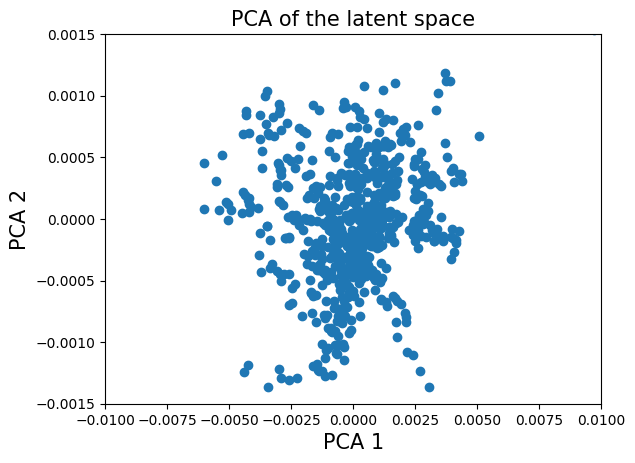

In [51]:
plt.plot(pca_fit[:,0],pca_fit[:,1],'o')
plt.xlim([-0.01,0.01]) 
plt.ylim([-0.0015,0.0015])
plt.xlabel('PCA 1',size=15)
plt.ylabel('PCA 2',size=15)
plt.title('PCA of the latent space',size=15)

#### TSNE

In [52]:
tsne = manifold.TSNE(n_components=2, perplexity=30.0, random_state=42)
z_tsne = tsne.fit_transform(mu.detach().cpu().numpy())

Text(0, 0.5, 't-SNE 2')

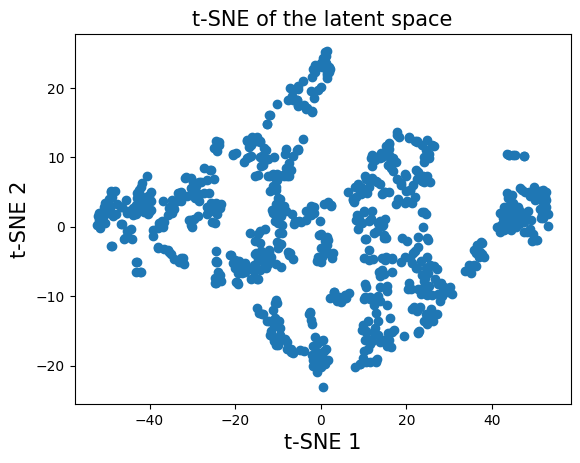

In [53]:
plt.plot(z_tsne[:,0],z_tsne[:,1],'o')
plt.title('t-SNE of the latent space',size=15)
plt.xlabel('t-SNE 1',size=15)
plt.ylabel('t-SNE 2',size=15)